#### customer_id ベースの 4-1 割引クーポンキャンペーンの効果最大化

In [49]:
from pulp import LpProblem, LpVariable
from pulp import LpMaximize, LpStatus, lpSum, value
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time

In [50]:
files = glob('../*/*coupon/*.csv')
dfs = [pd.read_csv(file) for file in files]
# for df in dfs:
#     display(df.head(3), df.shape)

In [51]:
COST = [0, 1000, 2000]
DM_SEND_MIN_RATE = 0.1
DM_COST = {i+1:c for i, c in enumerate(COST)}

In [52]:
c_df, p_df = dfs[0], dfs[1]

In [53]:
c_p_df = pd.merge(c_df, p_df, on=['age_cat', 'freq_cat'])

# prob_dm1 複製
c_p_df['prob1'] = c_p_df['prob_dm1']
c_p_df = c_p_df.rename(columns={dm: i+1 for i, dm in enumerate(p_df.columns[3:])})

# Prob_dm1, 2, 3 縦並び化
c_p_df = pd.melt(c_p_df, id_vars=['customer_id', 'age_cat', 'freq_cat', 'segment_id', 'prob1'], var_name='dm_type', value_name='prob')

# cost作成
c_p_df['dm_cost'] = c_p_df['dm_type'].apply(lambda x: DM_COST[x])

# 変数作成
c_p_df['variable'] = [LpVariable(name=f'x_id_dm({r.customer_id:03},{r.dm_type})', cat='Binary') for r in c_p_df.itertuples()]

c_p_df.head(3)

,customer_id,age_cat,freq_cat,segment_id,prob1,dm_type,prob,dm_cost,variable
0,1,age20~34,freq2,7,0.42,1,0.42,0,"x_id_dm(001,1)"
1,2,age35~49,freq0,9,0.08,1,0.08,0,"x_id_dm(002,1)"
2,3,age35~49,freq0,9,0.08,1,0.08,0,"x_id_dm(003,1)"


In [54]:
# 数理モデル
m = LpProblem('DiscountCouponProblem01_customer', sense=LpMaximize)

# DM効果最大化
m += lpSum((c_p_df['prob'] - c_p_df['prob1']) * c_p_df['variable'])

# id 割りあて
for k, r in c_p_df.groupby('customer_id'):
    m += lpSum(r['variable']) == 1

# segment 最低割合
for k, r in c_p_df.groupby(['segment_id', 'dm_type']):
    m += lpSum(r['variable'].sum()) >= lpSum(r['customer_id'].count()) * DM_SEND_MIN_RATE

# コスト制約
m += lpSum(c_p_df['dm_cost'] * c_p_df['prob'] * c_p_df['variable']) <= 1000000


In [55]:
# solve
start = time.time()
status = m.solve()
end = time.time()

# result
print(f'Status: {LpStatus[status]}')
print(f'Result: {value(m.objective):.02f}')
print(f'Time: {end - start:.02f} [sec]')

Status: Optimal
Result: 326.09
Time: 6.29 [sec]


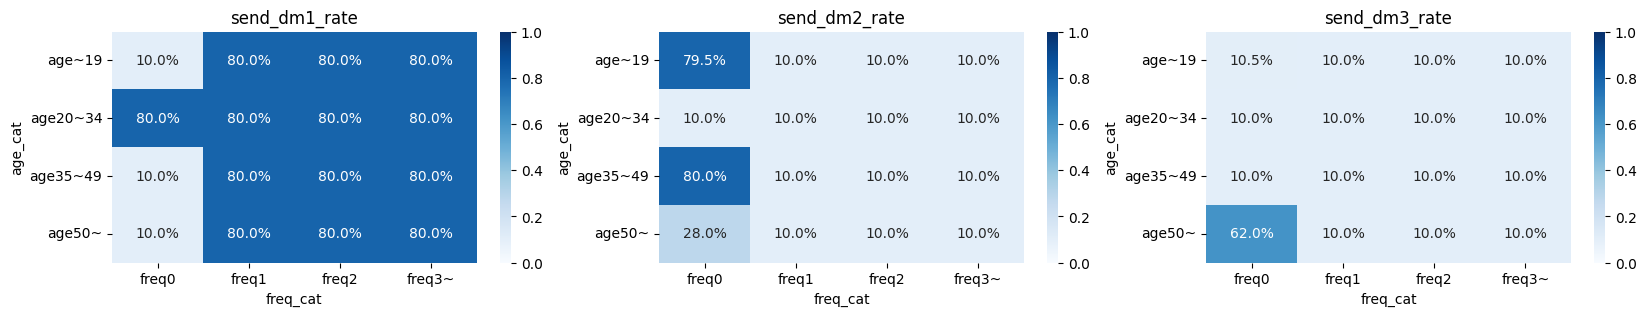

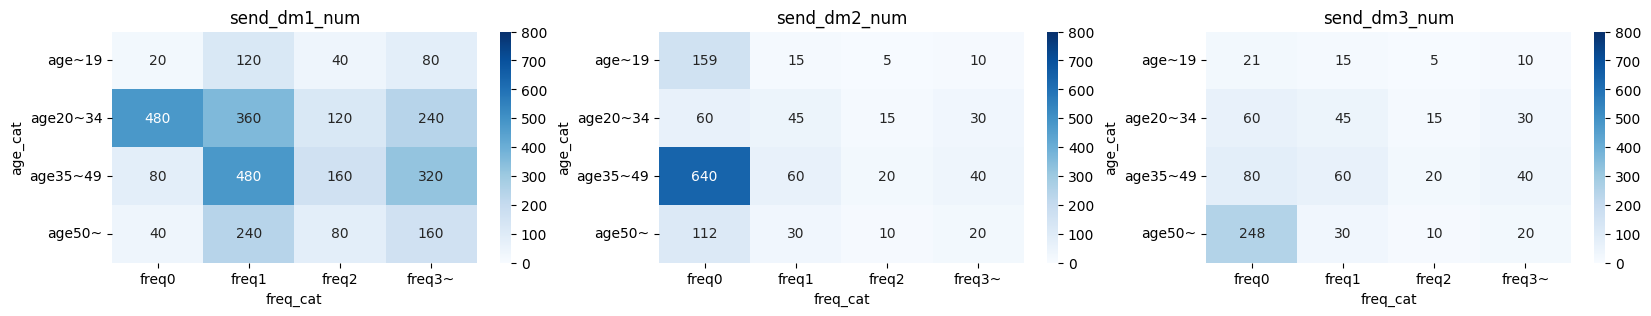

In [56]:
# result_df 作成
c_p_df['result'] = c_p_df['variable'].apply(value)

result_df = c_p_df.pivot(index=['customer_id'], columns='dm_type', values='result').reset_index(drop=True)
result_df.columns = ['send_dm1', 'send_dm2', 'send_dm3']
cust_send_df = pd.concat([c_df[['customer_id', 'age_cat', 'freq_cat']], result_df], axis=1)
cust_send_df.head()

def plot(cust_send_df, aggfunc, vmax, fmt, text):
    fig, axs = plt.subplots(1, 3, figsize=(20, 3))
    for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
        pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc=aggfunc)
        pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
        sns.heatmap(pivot_df, vmin=0, vmax=vmax, annot=True, fmt=fmt, cmap='Blues', ax=axs[i])
        axs[i].set_title(f'{ptn}_{text}')


plot(cust_send_df, 'mean', 1, '.1%', f'rate')
plot(cust_send_df, 'sum', 800, '.0f', f'num')

In [57]:
cust_send_df

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0
...,...,...,...,...,...,...
4995,4996,age50~,freq0,0.0,0.0,1.0
4996,4997,age50~,freq0,0.0,1.0,0.0
4997,4998,age35~49,freq1,1.0,0.0,0.0
4998,4999,age50~,freq1,1.0,0.0,0.0
